In [8]:
!pip install jovian -q

In [9]:
!pip install wordcloud -q

In [10]:
!pip install emoji -q

In [11]:
!pip install dateparser -q

In [12]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter
import dateparser

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Datetime format
    * http://strftime.org/

In [13]:
def rawToDf(file):
    with open('Brooke.txt', 'r') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split('\[\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}:\d{2}\s[APap][mM]\]\s', raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall('\[\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}:\d{2}\s[APap][mM]\]\s', raw_string) # finds all the date-time patterns
         
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
   
    # converting date-time pattern which is of type String to type datetime, format is to be specified for the whole string where the placeholders are extracted by the method    
    df['date_time'] = df['date_time'].apply(lambda x: dateparser.parse(x))
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [14]:
user_msg

NameError: name 'user_msg' is not defined

In [15]:
me = "Navi"

### Data

In [18]:
df = rawToDf('Brooke.txt')

In [19]:
df.head()

,date_time,user,msg
0,2019-08-01 18:11:01,Brooke,‎Messages to this chat and calls are now secur...
1,2019-08-01 18:11:01,Brooke,Tanya asked about you ☺
2,2019-08-01 19:58:41,Navi,Aww. How is she ? What did she say ?
3,2019-08-01 20:11:27,Brooke,"She’s good, also started classes this week so ..."
4,2019-08-01 20:19:46,Navi,So nice of her. Please say my thanks and Hell...


In [23]:
r = open('Brooke.txt')
r = r.readlines()
for x in r:
    print(x)

[8/1/2019, 6:11:01 PM] Brooke: ‎Messages to this chat and calls are now secured with end-to-end encryption.

[8/1/2019, 6:11:01 PM] Brooke: Tanya asked about you ☺

[8/1/2019, 7:58:41 PM] Navi: Aww. How is she ?

What did she say ?

[8/1/2019, 8:11:27 PM] Brooke: She’s good, also started classes this week so she’s adjusting to new schedule. 

She asked how you were and if we’d seen each other recently 😊

[8/1/2019, 8:19:46 PM] Navi: So nice of her. 

Please say my thanks and Hello to her.

Hope she fits well soon in the schedule.

[8/1/2019, 8:20:04 PM] Navi: How’s your school going ?

[8/1/2019, 8:25:25 PM] Navi: With* the schedule

[8/1/2019, 8:58:15 PM] Brooke: Will tell her ☺

[8/1/2019, 8:58:40 PM] Brooke: Good vibes so far 😊

[8/1/2019, 8:59:09 PM] Navi: Happy for you ☺️🤗

[8/1/2019, 8:59:18 PM] Brooke: How was your day?

[8/1/2019, 9:03:38 PM] Navi: It felt like yesterday continued to be today, hardly slept.

Good day though, had to go to Apple office. Now I have a professional 

In [24]:
df.head()

,date_time,user,msg
0,2019-08-01 18:11:01,Brooke,‎Messages to this chat and calls are now secur...
1,2019-08-01 18:11:01,Brooke,Tanya asked about you ☺
2,2019-08-01 19:58:41,Navi,Aww. How is she ? What did she say ?
3,2019-08-01 20:11:27,Brooke,"She’s good, also started classes this week so ..."
4,2019-08-01 20:19:46,Navi,So nice of her. Please say my thanks and Hell...


In [25]:
df.shape # no. of msgs

(735, 3)

### No. of Images, group notifications and dropping them

In [26]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(0, 3)

In [27]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(0, 3)

In [28]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [29]:
df.reset_index(inplace=True, drop=True)
df.shape

(735, 3)

## Q 1)
## Who is the most active member of the group. Who is the least active. Is it same on weekday weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [30]:
df.groupby("user")["msg"].count().sort_values()

user
Navi      366
Brooke    369
Name: msg, dtype: int64

In [31]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [32]:
df.weekday.value_counts(sort=True)

Sunday       186
Thursday     149
Wednesday    129
Tuesday       94
Friday        77
Monday        76
Saturday      24
Name: weekday, dtype: int64

In [33]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [34]:
df[df["is_weekend"]].groupby("user")["msg"].count().sort_values()

user
Navi      100
Brooke    110
Name: msg, dtype: int64

## Q 2)
## Count of all the emoticons that i have used till date.

In [35]:
df["user"].unique()

array(['Brooke', 'Navi'], dtype=object)

In [36]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [37]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

☺ - 38
🙈 - 37
🤗 - 11
💕 - 4
😴 - 3
🤷‍♂️ - 3
❤ - 3
😜 - 2
😊 - 2
🙄 - 2


## Q 3)
## What can my activity say about my sleep cycle?

In [38]:
def to_hour(val):
    return val.hour

In [39]:
df['hour'] = df['date_time'].apply(to_hour)

In [40]:
df_top5['hour'] = df_top5['date_time'].apply(to_hour)

NameError: name 'df_top5' is not defined

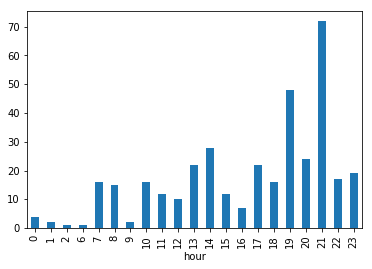

In [41]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?



In [42]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Brooke    369
Navi      366
Name: user, dtype: int64

top5_users = msgs_per_user.index.tolist()[:5]
top5_users

In [43]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

NameError: name 'top5_users' is not defined

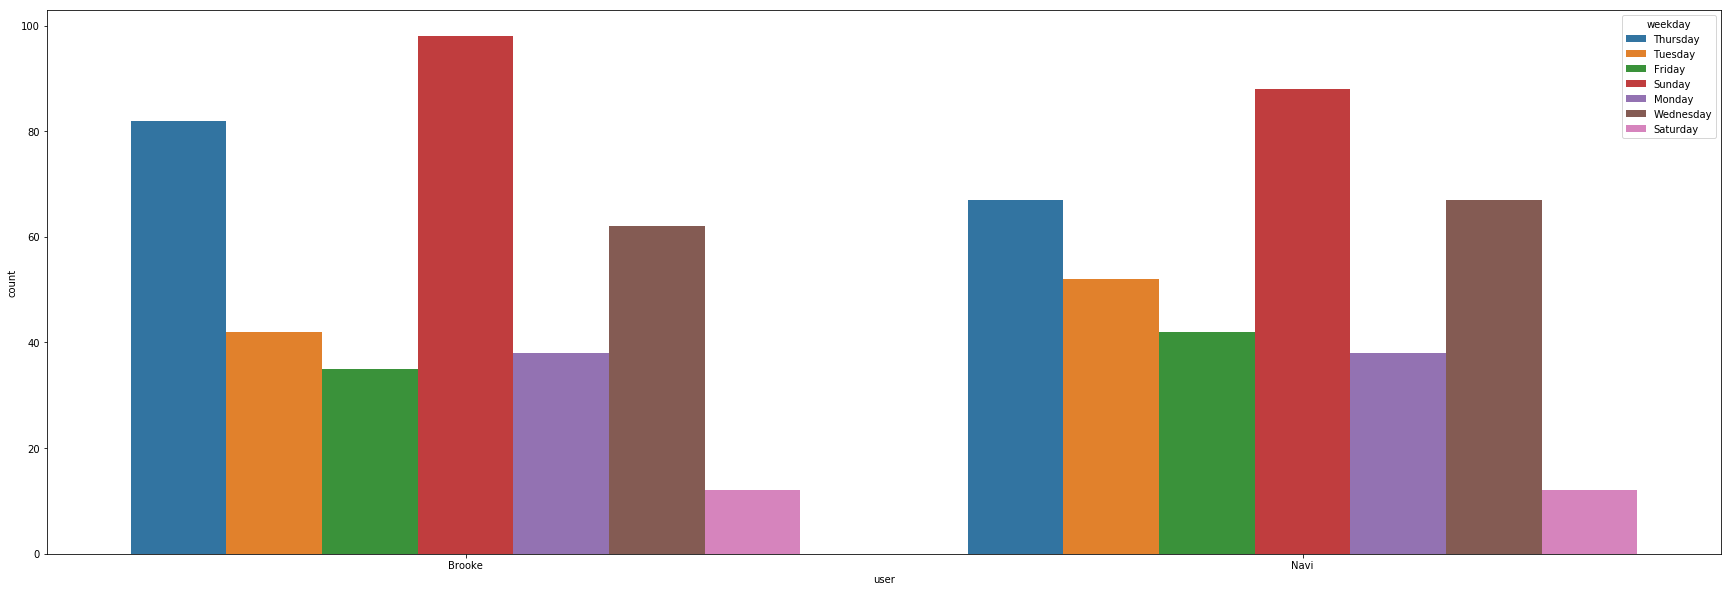

In [44]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [45]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

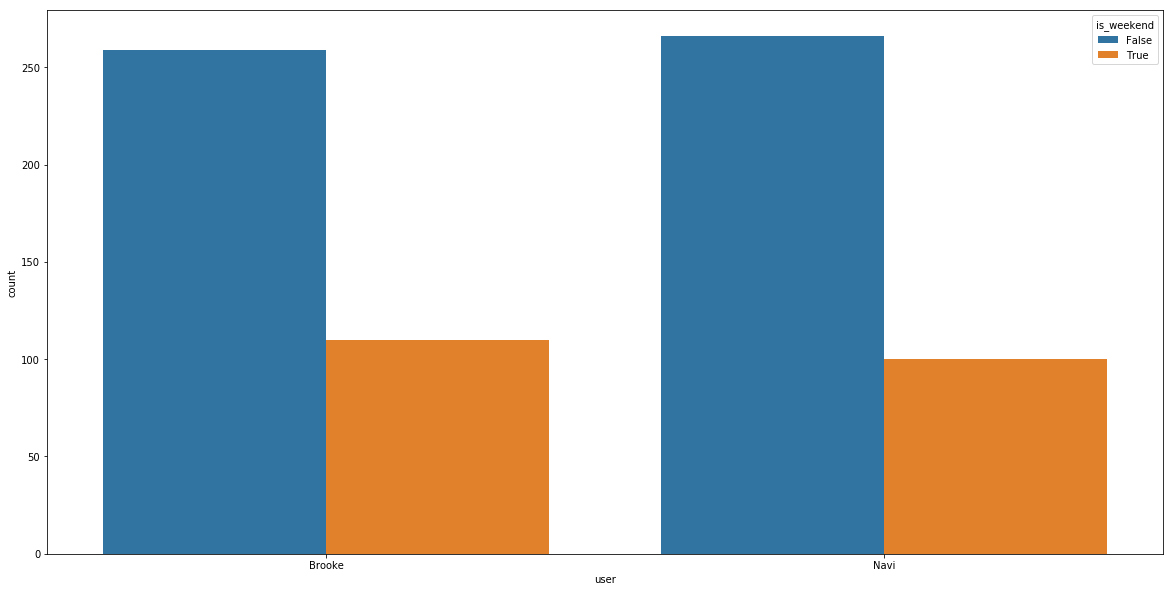

In [46]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [47]:
def word_count(val):
    return len(val.split())

In [48]:
df['no_of_words'] = df['msg'].apply(word_count)

In [49]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [50]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

3377

In [51]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

1101

In [52]:
total_words_weekday/5

675.4

In [53]:
total_words_weekend/2

550.5

In [54]:
df1_1 = df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)
df1_1.head(10)

user
Navi      2312
Brooke    2166
Name: no_of_words, dtype: int64

In [55]:
(df.groupby('user')['no_of_words'].sum()/df.groupby('user').size()).sort_values(ascending=False)

user
Navi      6.316940
Brooke    5.869919
dtype: float64

In [56]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Navi      6.316940
Brooke    5.869919
dtype: float64

In [57]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user    is_weekend
Brooke  False         6.185328
        True          5.127273
Navi    False         6.672932
        True          5.370000
dtype: float64

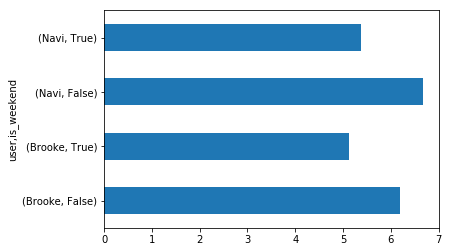

In [58]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [59]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,1.0,NaN,NaN,7.0,NaN,NaN,NaN
1,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,14.0,3.0,9.0,1.0,8.0,NaN,1.0
8,8.0,NaN,NaN,1.0,NaN,NaN,18.0
9,NaN,3.0,NaN,NaN,5.0,NaN,1.0
10,NaN,4.0,NaN,7.0,11.0,NaN,6.0
11,1.0,5.0,NaN,4.0,3.0,NaN,8.0


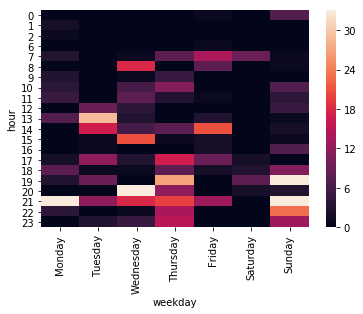

In [60]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [61]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[  2   4   5   6   9  11  12  14  17  18  20  24  25  28  29  30  31  36
  38  39  43  46  47  49  51  54  55  57  60  61  62  64  65  66  68  69
  71  73  75  76  78  82  84  87  88  89  92  93  94  96  97 100 101 103
 104 108 109 110 111 113 115 116 117 119 121 124 125 127 131 133 135 136
 138 139 142 143 145 146 149 150 153 156 157 159 161 163 165 168 169 172
 173 180 181 182 188 192 194 196 198 200 201 204 207 210 213 214 216 217
 220 224 226 227 229 231 233 237 238 239 241 243 247 252 254 255 258 259
 262 265 267 269 271 272 274 276 277 278 279 284 285 286 287 288 289 290
 293 295 297 299 300 303 304 306 308 309 311 312 315 320 323 326 327 329
 332 337 339 340 343 346 347 350 352 353 355 357 359 360 362 364 365 367
 368 369 372 375 376 378 380 381 383 384 385 387 388 390 395 396 398 399
 402 403 404 405 407 409 411 413 416 417 418 421 423 425 427 428 429 431
 434 436 438 441 442 443 446 449 452 454 456 458 461 463 465 466 468 469
 472 474 475 477 478 480 481 483 487 488 491 494 49

In [62]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[  1   3   4   5   8  10  11  13  16  17  19  23  24  27  28  29  30  35
  37  38  42  45  46  48  50  53  54  56  59  60  61  63  64  65  67  68
  70  72  74  75  77  81  83  86  87  88  91  92  93  95  96  99 100 102
 103 107 108 109 110 112 114 115 116 118 120 123 124 126 130 132 134 135
 137 138 141 142 144 145 148 149 152 155 156 158 160 162 164 167 168 171
 172 179 180 181 187 191 193 195 197 199 200 203 206 209 212 213 215 216
 219 223 225 226 228 230 232 236 237 238 240 242 246 251 253 254 257 258
 261 264 266 268 270 271 273 275 276 277 278 283 284 285 286 287 288 289
 292 294 296 298 299 302 303 305 307 308 310 311 314 319 322 325 326 328
 331 336 338 339 342 345 346 349 351 352 354 356 358 359 361 363 364 366
 367 368 371 374 375 377 379 380 382 383 384 386 387 389 394 395 397 398
 401 402 403 404 406 408 410 412 415 416 417 420 422 424 426 427 428 430
 433 435 437 440 441 442 445 448 451 453 455 457 460 462 464 465 467 468
 471 473 474 476 477 479 480 482 486 487 490 493 49

In [63]:
prev_msgs_index = np.delete(prev_msgs_index, 0)
prev_msgs_index

array([  3,   4,   5,   8,  10,  11,  13,  16,  17,  19,  23,  24,  27,
        28,  29,  30,  35,  37,  38,  42,  45,  46,  48,  50,  53,  54,
        56,  59,  60,  61,  63,  64,  65,  67,  68,  70,  72,  74,  75,
        77,  81,  83,  86,  87,  88,  91,  92,  93,  95,  96,  99, 100,
       102, 103, 107, 108, 109, 110, 112, 114, 115, 116, 118, 120, 123,
       124, 126, 130, 132, 134, 135, 137, 138, 141, 142, 144, 145, 148,
       149, 152, 155, 156, 158, 160, 162, 164, 167, 168, 171, 172, 179,
       180, 181, 187, 191, 193, 195, 197, 199, 200, 203, 206, 209, 212,
       213, 215, 216, 219, 223, 225, 226, 228, 230, 232, 236, 237, 238,
       240, 242, 246, 251, 253, 254, 257, 258, 261, 264, 266, 268, 270,
       271, 273, 275, 276, 277, 278, 283, 284, 285, 286, 287, 288, 289,
       292, 294, 296, 298, 299, 302, 303, 305, 307, 308, 310, 311, 314,
       319, 322, 325, 326, 328, 331, 336, 338, 339, 342, 345, 346, 349,
       351, 352, 354, 356, 358, 359, 361, 363, 364, 366, 367, 36

In [64]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(365, 7)

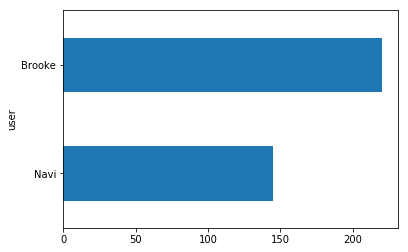

In [65]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

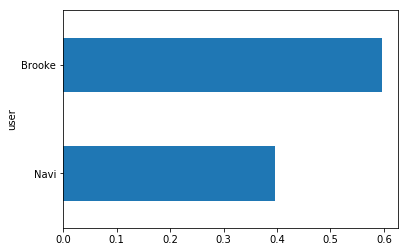

In [66]:
(df_replies.groupby(["user"])["msg"].size()/df.groupby(["user"])["msg"].size()).sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [67]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will','image','ommited', 'omitted'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


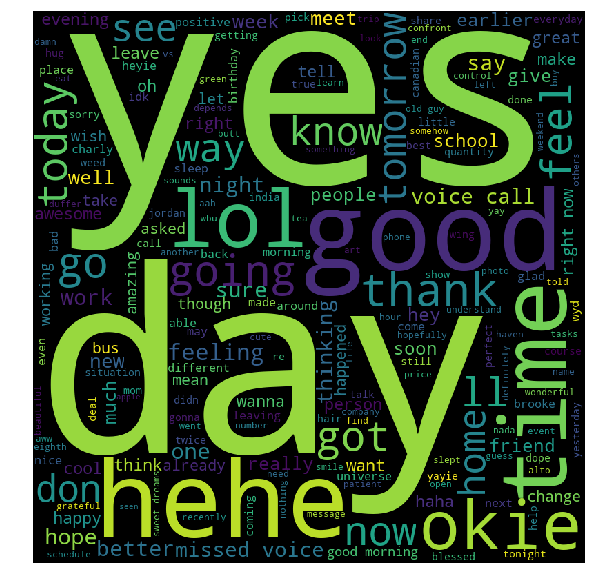

In [68]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

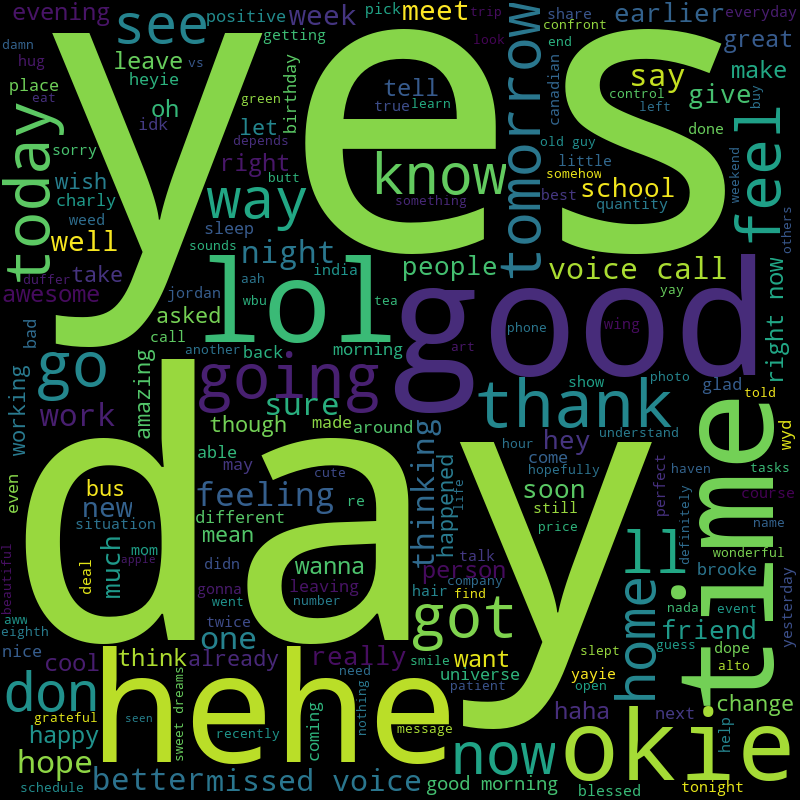

In [69]:
wordcloud.to_image()

Know What They Know(atleast by little
* Let this meetup series encourage people to work on their own data:
    * Ask many questions on whatsapp chat data, commit to jovian with your answers/analysis visulization. Experiment!!!
* Explore more data resources here's a list i could find, share if you find any @ dsnet.org
    * WhatsApp
    * Google take out (https://takeout.google.com/)
        * Keyboard
        * Maps
        * Calendar 
        * Chrome
        * Pay
        * etc....
    * https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/
    * https://in.pcmag.com/software/120204/how-to-download-your-facebook-data-and-6-surprising-things-i-found
* Lets move step by step and then move to some ML/DL Models 

* 1way ya 2way